# BioSig-BandVAE: Bandpass-Driven Variational Autoencoder for Interpretable and Compressed Biosignal Feature Generation

In [1]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.BioSigBandVAE_MultiM_Exp_deep_xfreq import *
from Utilities.Utilities import *
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

#### Env setting

In [2]:
SavePath = './Results/'
ModelName = 'SigBandRep_MultMod_Ext_Z5_ExpDeep_xfreq.hdf5'

### Model related parameters
LatDim = 5
MaskingRate = 0.02
NoiseStd = 0.002
MaskStd = 0.1
ReparaStd = 0.1
Capacity_Z = 0.1
Capacity_Fc = 0.1
FcLimit = 0.05
DecayH = 0. 
DecayL = 0.

### Other parameters
Patience = 300
TrRate = 0.8

if not os.path.exists(SavePath):
    os.mkdir(SavePath)

### Model checkpoint
ModelSaveName = SavePath+ModelName

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=Patience)

### Data

In [3]:
DATA = np.load('./Data/AsanTRSet.npy')
SigDim = DATA.shape[1]

np.random.seed(7)
PermutedDATA = np.random.permutation(DATA)
TrLen = int(PermutedDATA.shape[0] * TrRate)

TrData = PermutedDATA[:TrLen]
ValData = PermutedDATA[TrLen:]

### Post model

In [4]:
# Defining BioSigBandVAE
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=400)

## Model core parts
EncInp =EncModel.input
InpZ = EncModel.output[2]
InpFCCommon = EncModel.output[1][:, :2]
InpFCEach = EncModel.output[1][:, 2:]

## Each output of each model
FeatExtOut = FeatExtModel(EncModel.output[:2])
FeatGenOut = FeatGenModel([InpFCCommon, InpFCEach, InpZ])
ReconOut_ext = ReconModel(FeatExtOut)
ReconOut_gen = ReconModel(FeatGenOut)

### Define the total model
SigBandRepModel = Model(EncInp, [FeatGenOut, ReconOut_ext, ReconOut_gen])

### Weight controller; Apply beta and capacity 
Beta_Z = Lossweight(name='Beta_Z', InitVal=0.05)(FeatGenOut)
Beta_Fc = Lossweight(name='Beta_Fc', InitVal=0.05)(FeatGenOut)
Beta_Rec_ext = Lossweight(name='Beta_Rec_ext', InitVal=500.)(FeatGenOut)
Beta_Rec_gen = Lossweight(name='Beta_Rec_gen', InitVal=500.)(FeatGenOut)
Beta_Feat = Lossweight(name='Beta_Feat', InitVal=500.)(FeatGenOut)

### Adding the RecLoss; 
MSE = tf.keras.losses.MeanSquaredError()

ReconOut_ext = Beta_Rec_ext * MSE(ReconOut_ext, EncInp)
SigBandRepModel.add_loss(ReconOut_ext)
SigBandRepModel.add_metric(ReconOut_ext, 'ReconOut_ext')

#ReconOut_gen = Beta_Rec_gen * MSE(ReconOut_gen, EncInp)
#SigBandRepModel.add_loss(ReconOut_gen)
#SigBandRepModel.add_metric(ReconOut_gen, 'ReconOut_gen')


### Adding the FeatRecLoss; It allows connection between the extractor and generator
FeatRecLoss= Beta_Feat * MSE(tf.concat(FeatGenOut, axis=-1), tf.concat(FeatExtOut, axis=-1))
SigBandRepModel.add_loss(FeatRecLoss)
SigBandRepModel.add_metric(FeatRecLoss, 'FeatRecLoss')

### KL Divergence for p(Z) vs q(Z)
Z_Sampled, Z_Log_Sigma = SigBandRepModel.get_layer('Z_Mu').output, SigBandRepModel.get_layer('Z_Log_Sigma').output
kl_Loss_Z = 0.5 * tf.reduce_sum( Z_Sampled**2  +  tf.exp(Z_Log_Sigma)- Z_Log_Sigma-1, axis=1)    
kl_Loss_Z = tf.reduce_mean(kl_Loss_Z )
kl_Loss_Z = Beta_Z * tf.abs(kl_Loss_Z - Capacity_Z)

### KL Divergence for p(FCs) vs q(FCs)
BernP = 0.5 # hyperparameter
FCs = SigBandRepModel.get_layer('FC_Mu').output 
kl_Loss_FC = tf.math.log(FCs) - tf.math.log(BernP) + tf.math.log(1-FCs) - tf.math.log(1-BernP) 
kl_Loss_FC = tf.reduce_mean(-kl_Loss_FC )
kl_Loss_FC = Beta_Fc * tf.abs(kl_Loss_FC - Capacity_Fc)

SigBandRepModel.add_loss(kl_Loss_Z )
SigBandRepModel.add_metric(kl_Loss_Z , 'kl_Loss_Z')

SigBandRepModel.add_loss(kl_Loss_FC )
SigBandRepModel.add_metric(kl_Loss_FC , 'kl_Loss_FC')

### Load weights
SigBandRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigBandRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_Rec_ext','Beta_Rec_gen', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigBandRepModel.compile(optimizer='adam') 



In [66]:
SigBandRepModel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_42 (TFOpLambda) (None, 10, 100)      0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
dense_174 (Dense)               (None, 10, 50)       5050        tf.signal.frame_42[0][0]         
__________________________________________________________________________________________________
bidirectional_72 (Bidirectional (None, 10, 60)       14760       dense_174[0][0]                  
____________________________________________________________________________________________

#### Model evaluation

In [ ]:
SigBandRepModel.evaluate(TrData,  batch_size=3500, verbose=1)

### Extractor to Recon validation 

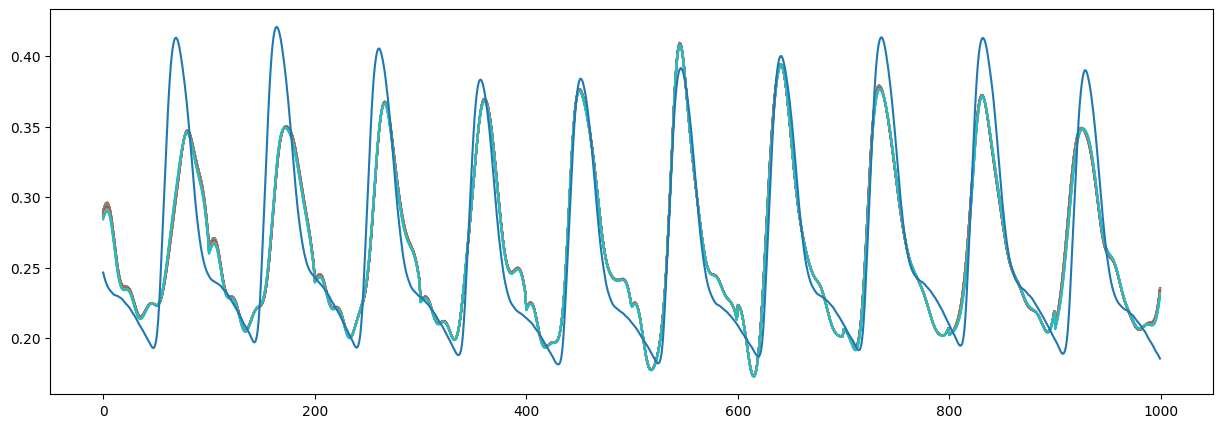

In [16]:
N_Exp = 200
idx = 1781

Sample = np.tile(ValData[idx][None], (N_Exp, 1))

FC_Comm = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,4))

#FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Exp)[:, None], (1,2))
#FC_Comm = np.sort(FC_Comm)
#FC_Each = np.tile(np.random.uniform(0, 0.05, N_Exp)[:, None], (1,4))
#FC_Each = np.sort(FC_Each)

FCs = np.concatenate([FC_Comm, FC_Each], axis=-1)
HH,HL,LH, LL = FeatExtModel([Sample, FCs])
RecPred = ReconModel([HH,HL,LH, LL])

plt.figure(figsize=(15, 5))
for i in range(20):
    plt.plot(RecPred[i])
plt.plot(ValData[idx])

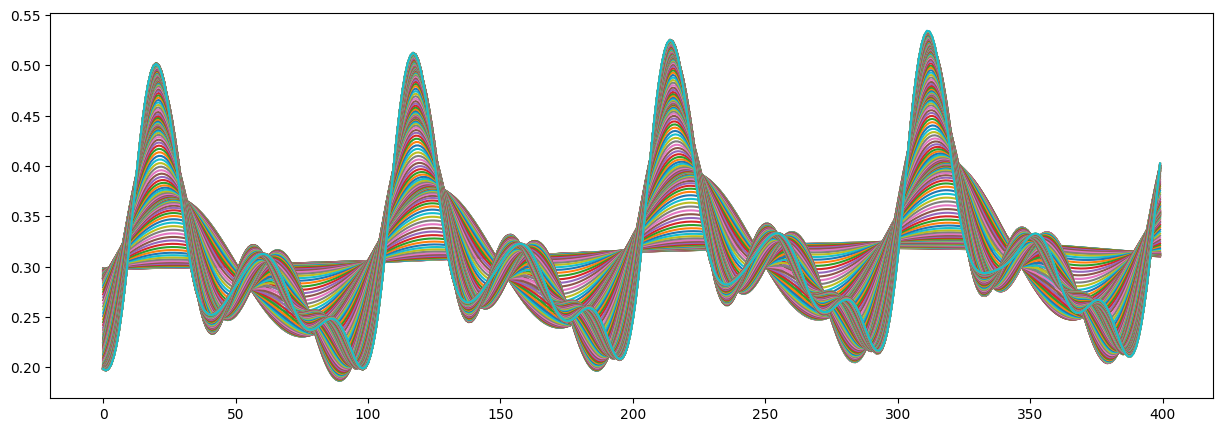

In [7]:
plt.figure(figsize=(15, 5))
for i in range(N_Exp):
    plt.plot(LL.numpy()[i])

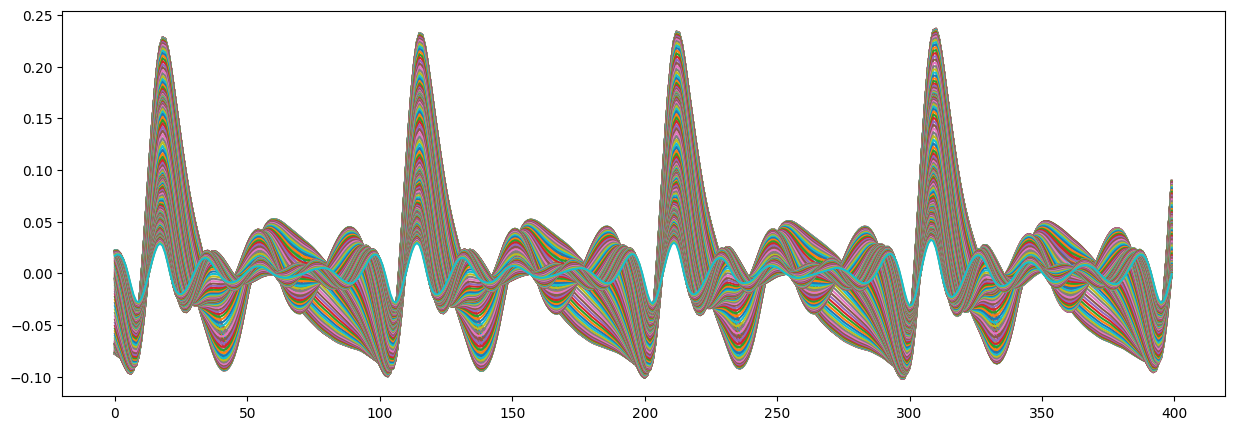

In [8]:
plt.figure(figsize=(15, 5))
for i in range(N_Exp):
    plt.plot(HH.numpy()[i])

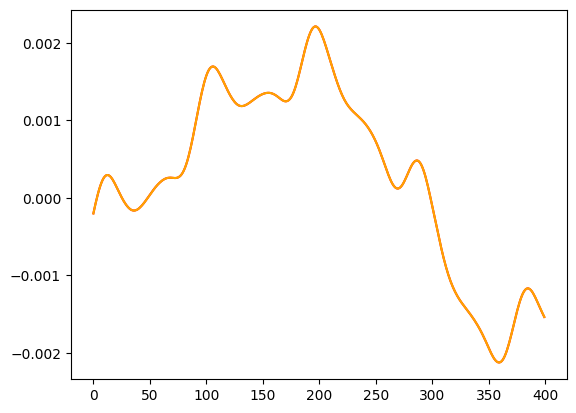

In [67]:
idx = 5
#plt.plot(HH[idx])
plt.plot(HL[idx], color='red')
plt.plot(LH[idx], color='orange')
#plt.plot(LL[idx])

In [ ]:
'using techniques such as histogram plots, Q-Q plots, or statistical tests like the Shapiro-Wilk test or the Kolmogorov-Smirnov test'

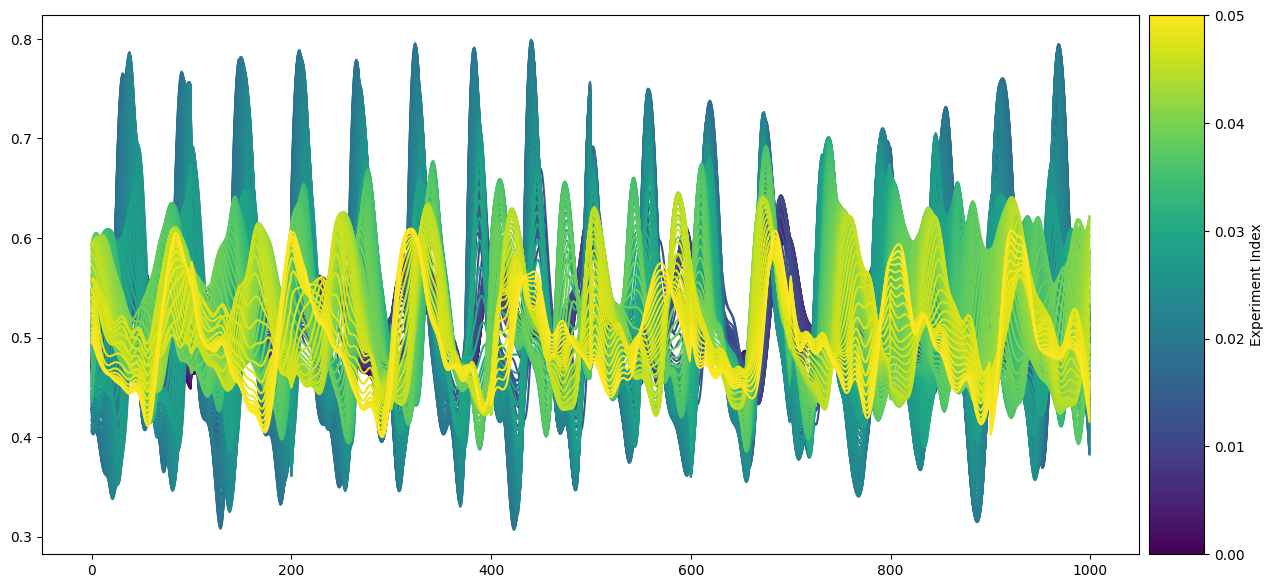

In [18]:
N_Exp = 200

Z_pred = np.tile(np.zeros(LatDim)-1.0, (N_Exp,1))
'''
Z_pred[:,0] = 2.
Z_pred[:,1] = 2.
Z_pred[:,2] = 2.
Z_pred[:,3] = 2.
Z_pred[:,4] = 2.
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Exp )[:, None], (1,4))


#FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Exp)[:, None], (1,2))
#FC_Comm = np.sort(FC_Comm)
#FC_Each = np.tile(np.random.uniform(0, 0.05, N_Exp)[:, None], (1,4))
#FC_Each = np.sort(FC_Each)


FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
SigGen = ReconModel([FeatGen])


# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Exp-1)
norm2 = plt.Normalize(0, 0.05)


fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Exp):
    color = cmap(norm(i))
    #ax.plot(FeatGen[0][i], color=color)
    ax.plot(SigGen[i], color=color)
    

# Create color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Experiment Index')

plt.show()


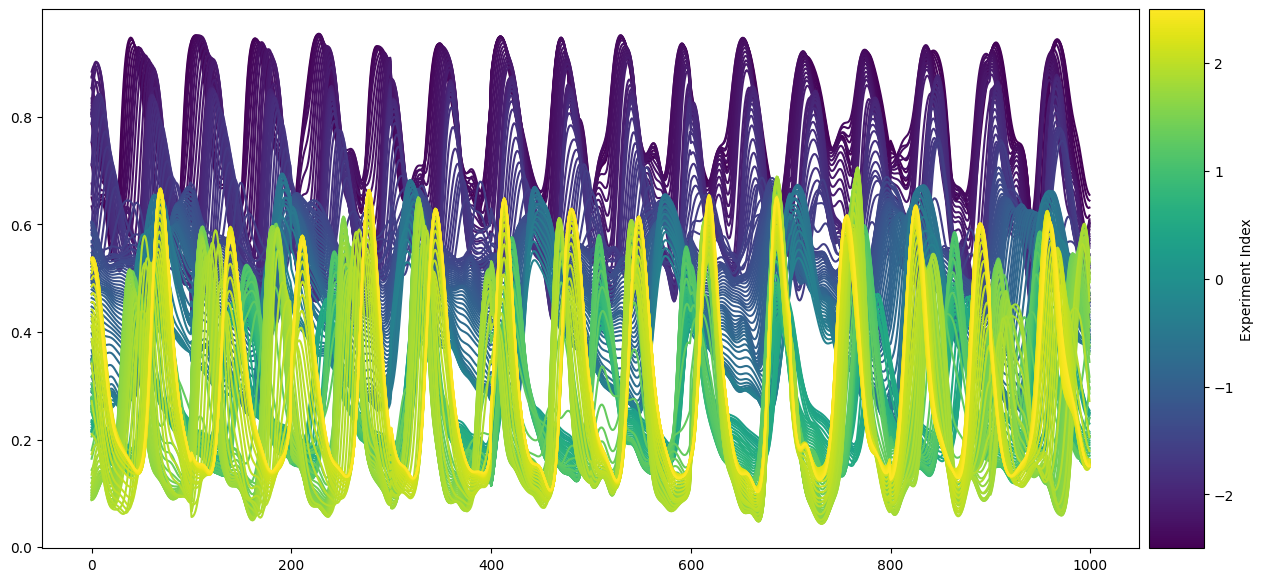

In [19]:
N_Exp = 200
Lower = -2.5
Upper = 2.5
CutLower = -0.3
CutUpper = 0.3


Z_pred = np.linspace(Lower, Upper, N_Exp*LatDim).reshape(N_Exp, -1)
#Z_pred[:, 0] = Z_pred[:, 0][::-1]
#Z_pred[:, 2] = Z_pred[:, 2][::-1]
FC_Comm = np.tile(np.ones(2) * 0.05, (N_Exp,1))
FC_Each = np.tile(np.ones(4) * 0.05, (N_Exp,1))


FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
SigGen = ReconModel([FeatGen])

# Create a colormap and normalize it based on the number of experiments
cmap = cm.get_cmap('viridis')
norm = plt.Normalize(0, N_Exp-1)
norm2 = plt.Normalize(Lower, Upper)


fig, ax = plt.subplots(figsize=(15, 7))
for i in range(0, N_Exp):
    color = cmap(norm(i))
    #ax.plot(FeatGen[3][i], color=color)

    if np.min(Z_pred[i]) < CutLower or np.max(Z_pred[i]) > CutUpper:
        ax.plot(SigGen[i], color=color)
        #ax.plot(FeatGen[2][i], color=color)
    

# Create color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Experiment Index')

plt.show()

In [15]:
N_Exp = 3
FCTmp= np.linspace(0.,0.05, N_Exp)

FCa, FCb, FCc, FCd, FCe, FCf = np.meshgrid(FCTmp, FCTmp, FCTmp, FCTmp,  FCTmp,  FCTmp)
FC_Comm = np.concatenate([FCa.ravel()[:, None], FCb.ravel()[:, None]], axis=1)
FC_Each = np.concatenate([FCc.ravel()[:, None], FCd.ravel()[:, None], FCe.ravel()[:, None], FCf.ravel()[:, None]   ], axis=1)

Z_pred = np.tile(np.zeros(LatDim), (FC_Comm.shape[0],1))
FeatGen = FeatGenModel([FC_Comm, FC_Each,  Z_pred])



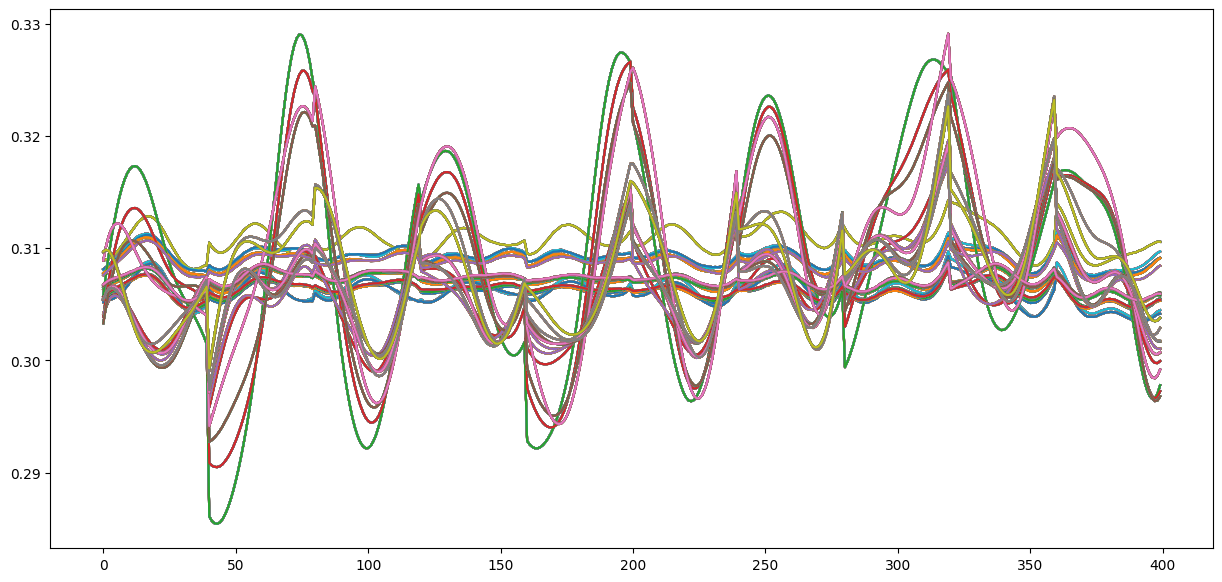

In [100]:
fig, ax = plt.subplots(figsize=(15, 7))

for i in range(0, Z_pred.shape[0]):
    plt.plot(FeatGen[3][i])

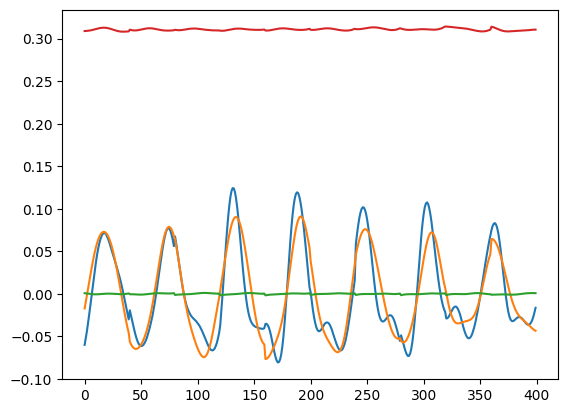

In [16]:
plt.plot(FeatGen[0][10])
plt.plot(FeatGen[1][10])
plt.plot(FeatGen[2][10])
plt.plot(FeatGen[3][0])

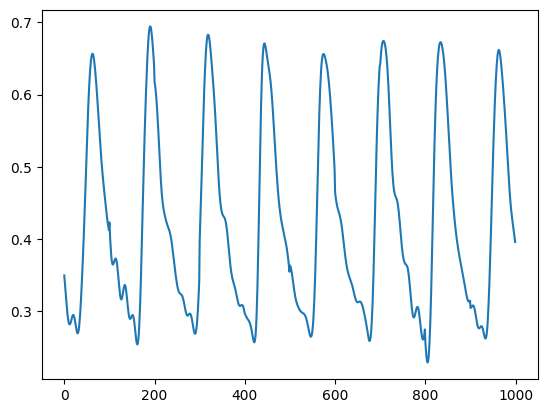

In [17]:
plt.plot(SigGen[78])

In [21]:
def GenSig_zVar (FC, N_Exp=200):
    Z_pred = np.linspace(-1.5, 1.5, N_Exp*LatDim).reshape(N_Exp, -1)
    FC_Comm = np.tile(np.ones(2) * FC, (N_Exp,1))
    FC_Each = np.tile(np.ones(4) * FC, (N_Exp,1))
    FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
    PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
    SigGen = ReconModel([FeatGen])

    HalfLen = SigGen.shape[1]//2
    FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    
    return SigGen, Amplitude


def GenSig_FcVar (zValue, N_Exp=200, zType='Fixed'):
    
    if zType=='Random':
        Z_pred=np.random.normal(0, 1, ( N_Exp, LatDim))
    elif zType=='Line' :
        Z_pred = np.linspace(-1.5, 1.5, N_Exp*LatDim).reshape(N_Exp, -1)
    elif zType=='Fixed':
        Z_pred = np.tile(np.zeros(LatDim)+zValue, (N_Exp,1))
        
        
    FC_Comm = np.tile(np.linspace(1e-7, 0.05, N_Exp )[:, None], (1,2))
    FC_Each = np.tile(np.linspace(1e-7, 0.05, N_Exp )[:, None], (1,4))

    FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
    PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
    SigGen = ReconModel([FeatGen])

    HalfLen = SigGen.shape[1]//2
    FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    
    return SigGen, Amplitude


def GenSig_ZFcVar (Z_pred, FC_Comm, FC_Each, FreqRange=[9,12]):

    #[GenSig_ZFcVar(zValues[i], FCValues[i]) for i in range(N_Exp)]
    FeatGen = FeatGenModel([FC_Comm,FC_Each, Z_pred])
    PredFCs = np.concatenate([FC_Comm,FC_Each], axis=-1)
    SigGen = ReconModel([FeatGen])

    HalfLen = SigGen.shape[1]//2
    FFTRes = np.abs(np.fft.fft(SigGen, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen
    
    return Amplitude[:, FreqRange[0]:FreqRange[1]+1].max(axis=-1)


# GenSig_zVar
N_Exp= 300
SigGen5, Amplitude5 = GenSig_zVar(0.05, N_Exp=N_Exp)
SigGen4, Amplitude4 = GenSig_zVar(0.04, N_Exp=N_Exp)
SigGen3, Amplitude3 = GenSig_zVar(0.03, N_Exp=N_Exp)
SigGen2, Amplitude2 = GenSig_zVar(0.02, N_Exp=N_Exp)
SigGen1, Amplitude1 = GenSig_zVar(0.01, N_Exp=N_Exp)




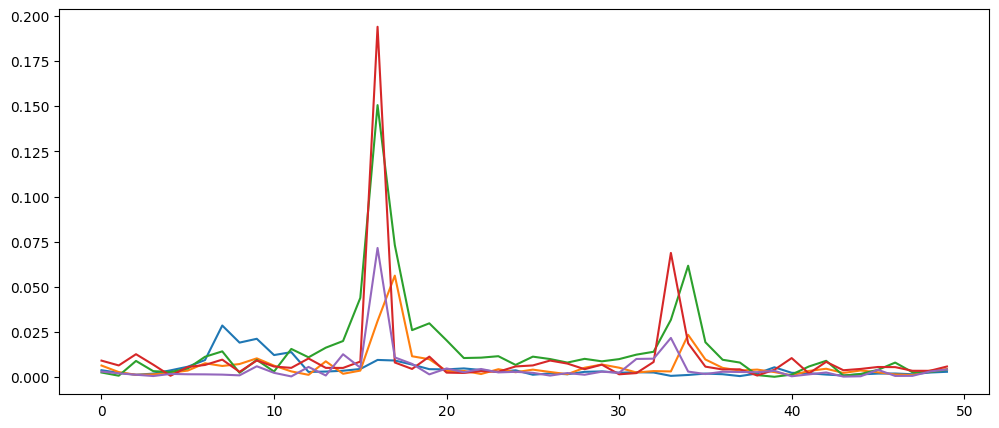

In [29]:
plt.figure(figsize=(12, 5))
idx = 20
plt.plot(Amplitude5[idx, 1:51])
plt.plot(Amplitude4[idx, 1:51])
plt.plot(Amplitude3[idx, 1:51])
plt.plot(Amplitude2[idx, 1:51])
plt.plot(Amplitude1[idx, 1:51])

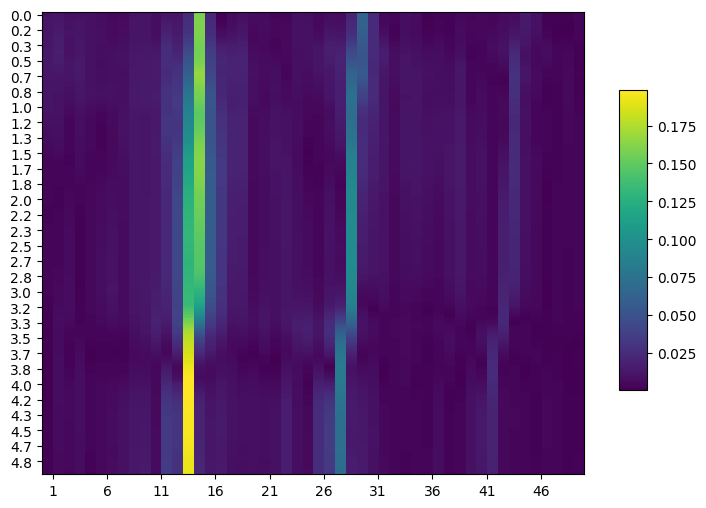

In [26]:
# GenSig_FcVar
zVal = 1.41
SigGen_FcVar, Amplitude_FcVar = GenSig_FcVar(zVal, N_Exp=N_Exp, zType='Fixed')


Heatmap = Amplitude_FcVar[:, 1:51]
Min = np.min(Heatmap, axis=1, keepdims=True)
Max = np.max(Heatmap, axis=1, keepdims=True)
NormHeatmap = (Heatmap - Min) / (Max - Min)

fig, ax = plt.subplots(figsize=(7,6))
cax = fig.add_axes([0.95, 0.25, 0.04, 0.5])

im = ax.imshow(Heatmap,  cmap='viridis', aspect='auto',interpolation='nearest') 
#ax.set(yticks=np.arange(1, 200)[::10], yticklabels=np.arange(1, 200)[::10]);
ax.set(yticks=np.arange(1, N_Exp)[::10], yticklabels=np.round(np.linspace(1e-7, 0.05, N_Exp )[::10]*100, 1));
ax.set(xticks=np.arange(1, 50)[::5]-0.5, xticklabels=np.arange(1, 50)[::5]);

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()


# 'Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'YlOrBr', 'YlOrRd', 'YlGn'  
# 'coolwarm', 'BrBG', 'PRGn', 'PiYG', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral' viridis
# 'tab10', 'tab20', 'hls', 'husl', 'Paired', 'Set1', 'Set2', 'Set3'

#ytick_labels = np.linspace(1e-7, 0.05, N_Exp ).round(5).tolist()
#ytick_positions = np.arange(0, len(ytick_labels), 1)  # 라벨 중앙에 위치하도록 조정
#plt.yticks( ytick_labels)



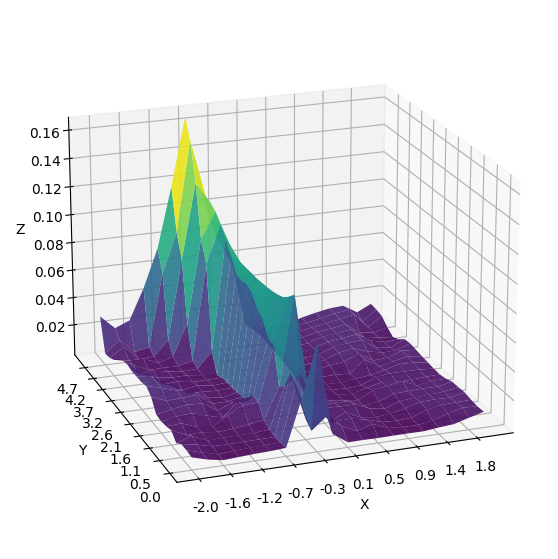

In [27]:
# GenSig_ZFcVar
FreqRange=[5,8]
N_Exp_ = 20
zValues = np.linspace(-1.5, 1.5, N_Exp_)
FCValues = np.linspace(1e-7, 0.05, N_Exp_ )
x_grid, y_grid = np.meshgrid(zValues,FCValues)
Z_pred = np.tile(x_grid.ravel()[:,None], (1,LatDim))
FC_Comm = np.tile(y_grid.ravel()[:,None], (1,2))
FC_Each = np.tile(y_grid.ravel()[:,None], (1,4))
MaxAmplitude =  GenSig_ZFcVar(Z_pred, FC_Comm, FC_Each,FreqRange=FreqRange)
MaxAmplitude = np.reshape(MaxAmplitude, (N_Exp_,N_Exp_))


x_grid, y_grid = np.meshgrid(zValues,FCValues)

# 3D 플롯 생성
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, MaxAmplitude, cmap='viridis', linewidth=1, antialiased=True, alpha = 0.9)

# 축 라벨 추가
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
Yticks = np.round(np.linspace(1e-7, 0.05, N_Exp_ ) * 100, 1)
Xticks = np.linspace(-2., 2., N_Exp_).round(1)
ax.set(yticks=FCValues[::2], yticklabels=Yticks[::2]);
ax.set(xticks=zValues[::2], xticklabels=Xticks[::2]);
ax.view_init(azim=250, elev=20)
plt.show()

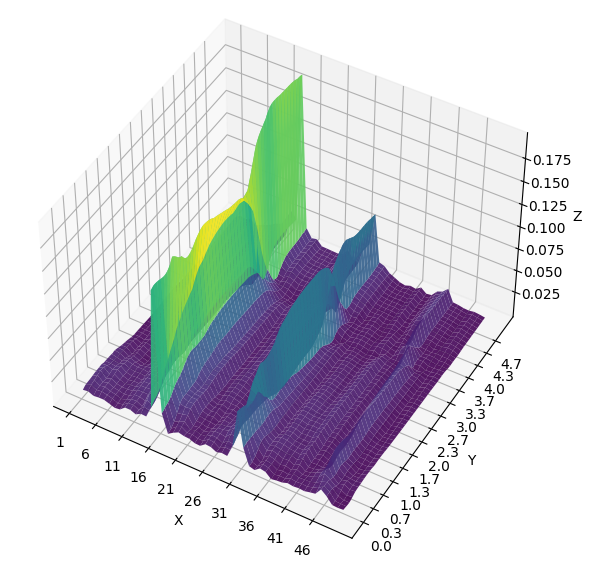

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 데이터 생성
X = np.arange(0, N_Exp)
Y = np.arange(1, 50)
x_grid, y_grid = np.meshgrid(Y, X)


# 3D 플롯 생성
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, Amplitude_FcVar[:, 1:50], cmap='viridis', linewidth=1, antialiased=True, alpha = 0.9)


# 축 라벨 추가
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set(yticks=np.arange(1, N_Exp)[::20], yticklabels=np.round(np.linspace(1e-7, 0.05, N_Exp )[::20]*100, 1));
ax.set(xticks=np.arange(1, 50)[::5]-0.5, xticklabels=np.arange(1, 50)[::5]);
ax.view_init(azim=300, elev=45)
plt.show()


In [27]:
def KernelGen (SortedWindow, MinIdx, WindowSize):
    
    TotalSpace = WindowSize-1
    LeftSpaceSize = MinIdx - 0 
    RightSpaceSize = WindowSize-LeftSpaceSize-1
    InterIDX = 1


    LeftSide = []
    RightSide = []

    # Kernel generation
    while LeftSpaceSize>0 or RightSpaceSize>0:

        if LeftSpaceSize>0:
            LeftSide.append(SortedWindow[InterIDX])
            InterIDX += 1
            LeftSpaceSize -= 1

        if RightSpaceSize>0:
            RightSide.append(SortedWindow[InterIDX])
            InterIDX += 1
            RightSpaceSize -= 1

    Kernel = np.concatenate([LeftSide[::-1], [SortedWindow[0]], RightSide])    
    
    return Kernel



def MonotonDegree (Vec, WindowSize):
    
    AbsRhoList = []
    Global_Variability = np.std(Vec)

    for i in range(len(Vec) - WindowSize+1):
        Window = Vec[i:i + WindowSize]

        # Create an ideal monotonic list based on the sorted vector
        SortedWindow = sorted(Window)

        SubRhos=[]
        # Compute Spearman's rho between Kernel and window
        for MinIdx in range(WindowSize):
            LeftSpaceSize = MinIdx - 0 

            Kernel = KernelGen(SortedWindow, MinIdx, WindowSize)
            #Kernel = sorted(Window)

            # Compute Spearman's rho
            SubRho = spearmanr(Window, Kernel)[0]

            # Appeding sub-Rho values
            SubRhos.append(abs(SubRho) * np.log(WindowSize)) # log(WindowSize) : Weighting by increasing window size

        AbsRhoList.append(max(SubRhos))


    return np.mean(AbsRhoList) #* Global_Variability # Global_Variability : Weighting by increasing total std.




In [29]:
N_Exp_ = 50
MonoWinSize = 20
zValues = np.linspace(-3., 3., N_Exp_)

for zVal in zValues:
    Amplitude_FcVar = GenSig_FcVar(zVal, N_Exp=N_Exp, zType='Fixed')[1]
    Heatmap = Amplitude_FcVar[:, 1:51]
    MaxIDX = np.argmax(np.mean(Heatmap, axis=0))
    Vec =  Heatmap[:, MaxIDX]
    print(np.round(zVal,2),  MonotonDegree(Vec, MonoWinSize).round(4))


-3.0 2.7731
-2.88 2.8258
-2.76 2.8607
-2.63 2.8388
-2.51 2.9129
-2.39 2.7945
-2.27 2.8543
-2.14 2.9085
-2.02 2.7939
-1.9 2.814
-1.78 2.8603
-1.65 2.7437
-1.53 2.8437
-1.41 2.8599
-1.29 2.7531
-1.16 2.7628
-1.04 2.7458
-0.92 2.7951
-0.8 2.8323
-0.67 2.8614
-0.55 2.8435
-0.43 2.8856
-0.31 2.8389
-0.18 2.9757
-0.06 2.9132
0.06 2.9115
0.18 2.9052
0.31 2.9688
0.43 2.8925
0.55 2.8596
0.67 2.9255
0.8 2.7231
0.92 2.8861
1.04 2.93
1.16 2.8918
1.29 2.9098
1.41 2.9835
1.53 2.8914
1.65 2.956
1.78 2.9484
1.9 2.9767
2.02 2.8772
2.14 2.9173
2.27 2.8866
2.39 2.9609
2.51 2.8945
2.63 2.975
2.76 2.9639
2.88 2.9544
3.0 2.984
